## Importación de librerias necesarias

In [60]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import cross_val_score
from utils import classification_report
from limpieza_df import train_test_split, standarize_X_train, standarize_X_test
from funciones_evaluacion_modelos import cv_model
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestClassifier # aunque los árboles no son muy robustos para datos atípicos es un buen ejemplo para mostrarlo y ver cuánto overfitting producen estos modelos con datasets donde los datos atípicos también son relevantes.
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

## Primero cogemos nuestro train split 

In [63]:
df_str = "FICO_Dataset.csv"
df = pd.read_csv(f"{df_str}", sep=";")

# Eliminamos los datos nulos de la columna output
df = df.dropna(subset=["RiskPerformance"])
# Eliminar las filas que contienen los valores -9 en cualquier columna
df = df[~df.isin([-9]).any(axis=1)]

inputs = list(df)[1:]
output = "RiskPerformance"
X = df[inputs]
y = df[output]

# Pasamos ahora a hacer el train test split

# Paso 1: Shuffle the data (check out the .sample() method in pandas)
df = df.sample(frac=1)

from sklearn.impute import KNNImputer

# Crear el imputador KNN con, por ejemplo, 2 vecinos
imputer = KNNImputer(weights="uniform")

df = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)

# Paso 3 dividir el conjunto
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train = standarize_X_train(X_train)
X_test = standarize_X_test(X_train, X_test)

## Ahora procedemos al entrenamiento de los modelos

## 1: KNN

In [4]:
knn_model = KNeighborsClassifier()
knn_model.fit(X_train, y_train)

KNeighborsClassifier()

Optimal value of k: 85 with a score of 0.7309879200222161


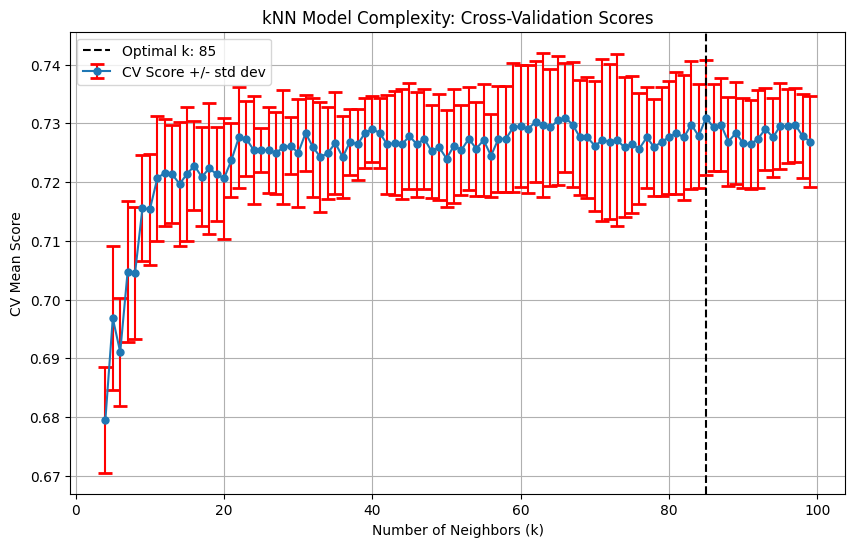

In [5]:
k_values = range(4,100)
mean_scores, std_scores, optimal_value_KNN_train, highest_score = cv_model(knn_model, X_train, y_train, k_values, "n_neighbors")

print(f"Optimal value of k: {optimal_value_KNN_train} with a score of {highest_score}")

# Plotting
plt.figure(figsize=(10, 6))
plt.errorbar(k_values, mean_scores, yerr=std_scores, fmt='-o', ecolor='r', capsize=5, capthick=2, markersize=5, label='CV Score +/- std dev')
plt.axvline(x=optimal_value_KNN_train, linestyle='--', color='k', label=f'Optimal k: {optimal_value_KNN_train}')

plt.title('kNN Model Complexity: Cross-Validation Scores')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('CV Mean Score')
plt.legend()
plt.grid(True)
plt.show()


#### Entrenamos el modelo con el parámetro óptimo

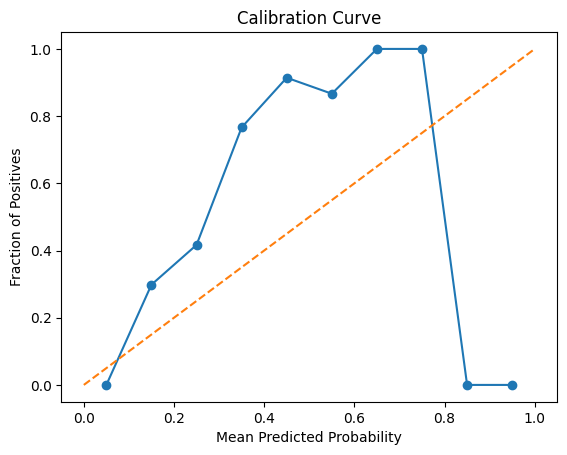

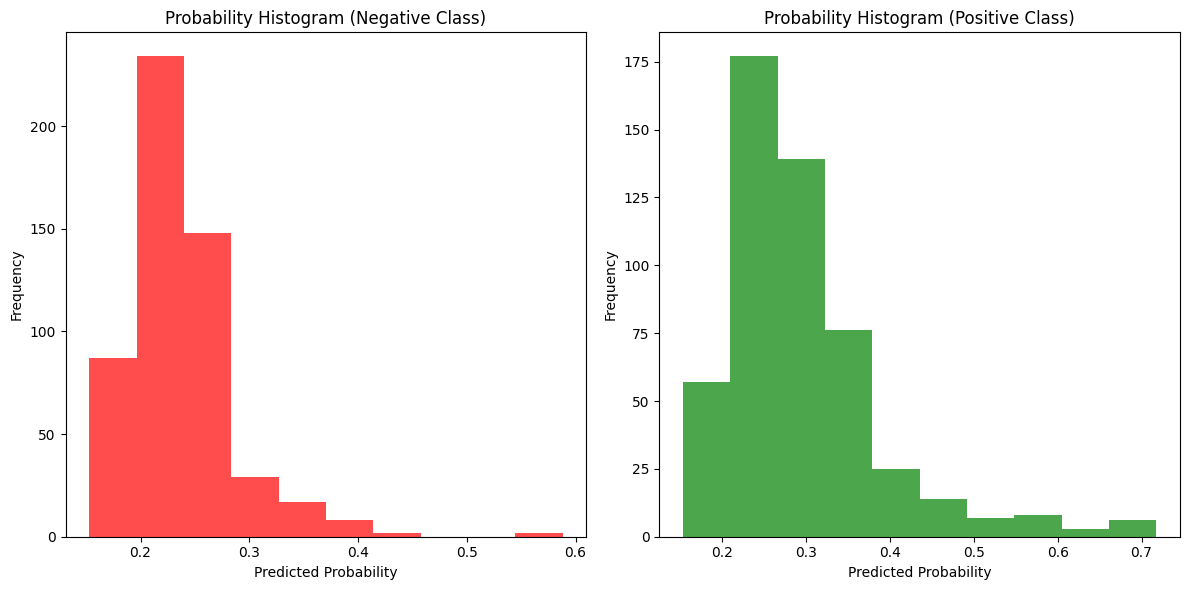

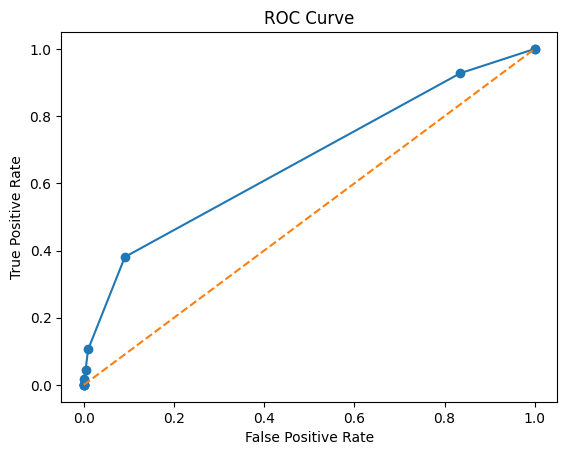

{'Confusion Matrix': [525, 2, 490, 22],
 'Accuracy': 0.5264677574590952,
 'Precision': 0.9166666666666666,
 'Recall': 0.04296875,
 'Specificity': 0.9962049335863378,
 'F1 Score': 0.08208955223880596}

In [6]:
knn_model = KNeighborsClassifier(n_neighbors=optimal_value_KNN_train)
knn_model.fit(X_train, y_train)
y_test_prob_knn = knn_model.predict_proba(X_test)
classification_report(y_test, y_test_prob_knn[:,1], 1)

## 2: Logistic Regression

In [7]:
logreg_model = LogisticRegression()
logreg_model.fit(X_train, y_train)

LogisticRegression()

Optimal value of C: 4 with a score of 0.7309902341942053


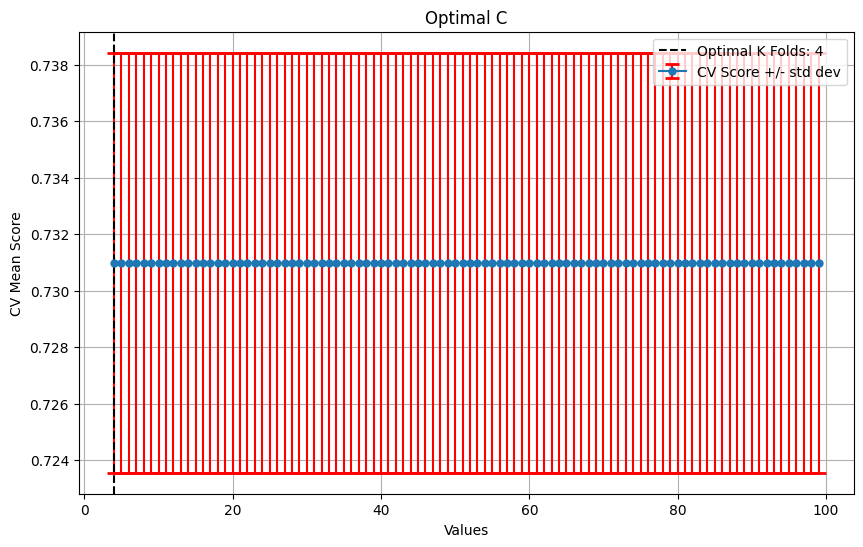

In [8]:
values = range(4,100)
mean_scores, std_scores, optimal_logregC_train, highest_score  = cv_model(logreg_model, X_train, y_train, values, "C")

print(f"Optimal value of C: {optimal_logregC_train} with a score of {highest_score}")

# Plotting
plt.figure(figsize=(10, 6))
plt.errorbar(k_values, mean_scores, yerr=std_scores, fmt='-o', ecolor='r', capsize=5, capthick=2, markersize=5, label='CV Score +/- std dev')
plt.axvline(x=optimal_logregC_train, linestyle='--', color='k', label=f'Optimal K Folds: {optimal_logregC_train}')

plt.title('Optimal C')
plt.xlabel('Values')
plt.ylabel('CV Mean Score')
plt.legend()
plt.grid(True)
plt.show()


#### Entrenamos el modelo con el parámetro óptimo

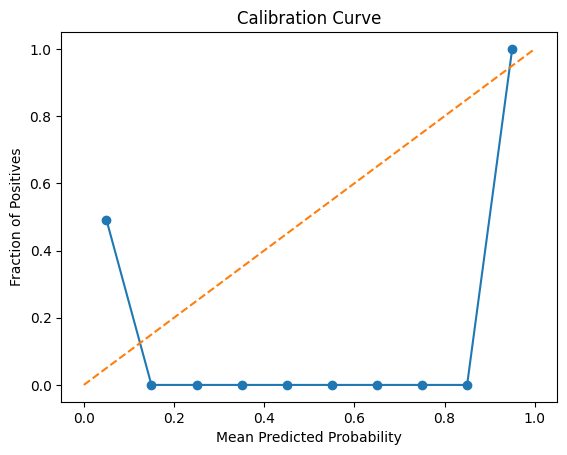

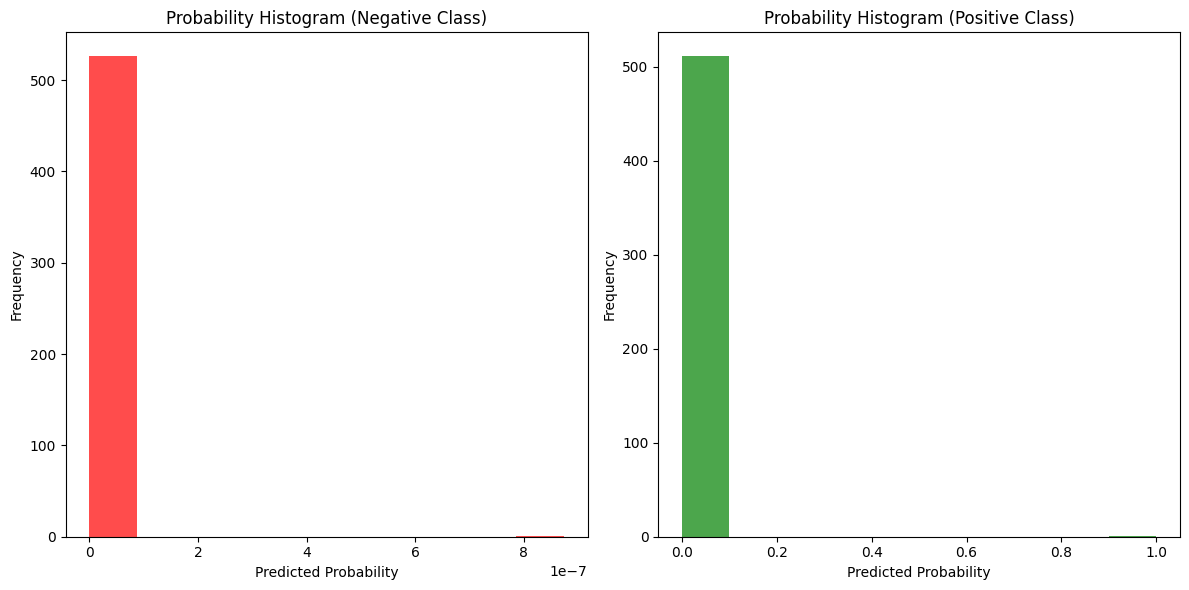

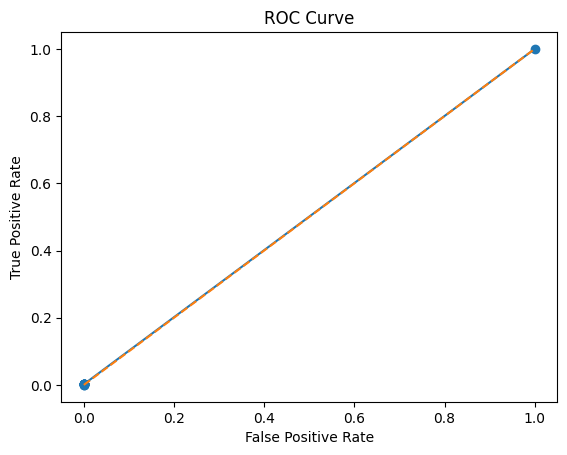

{'Confusion Matrix': [527, 0, 511, 1],
 'Accuracy': 0.5081809432146295,
 'Precision': 1.0,
 'Recall': 0.001953125,
 'Specificity': 1.0,
 'F1 Score': 0.003898635477582846}

In [9]:
logreg_model = LogisticRegression(C=optimal_logregC_train)
logreg_model.fit(X_train, y_train)
y_test_prob_logreg = logreg_model.predict_proba(X_test)
classification_report(y_test, y_test_prob_logreg[:,1], 1)

## 2.1: Lasso

The optimum value of C based on accuracy is: 1e-08


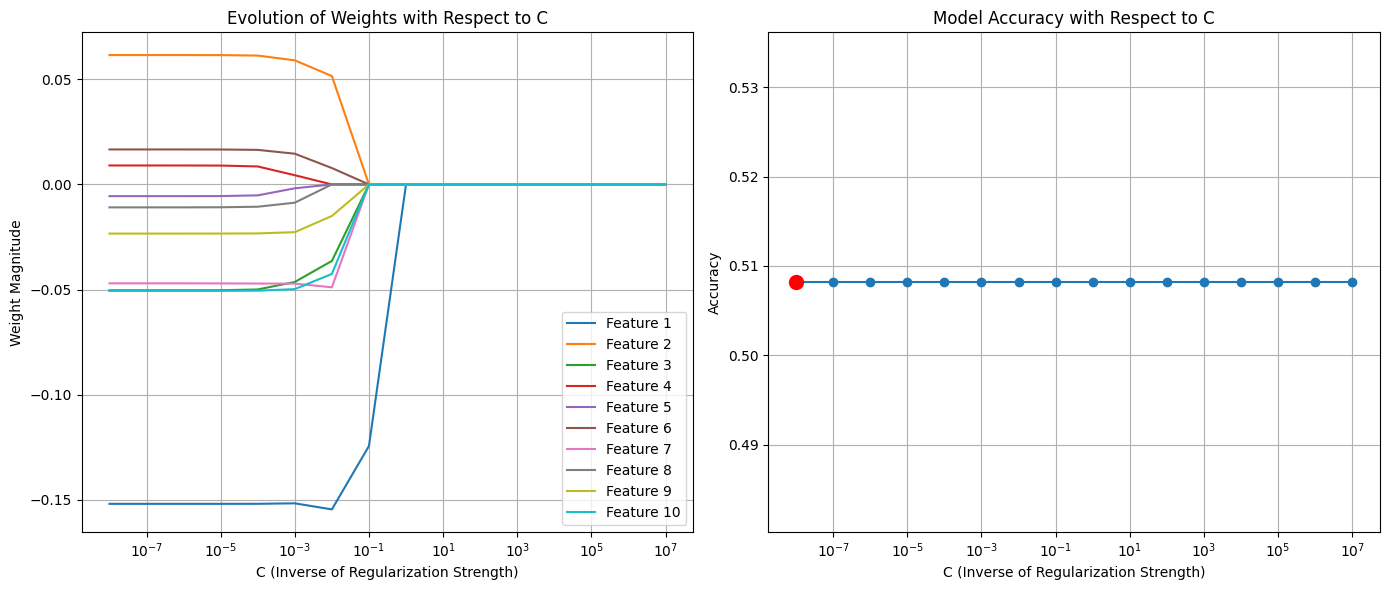

In [10]:
lasso_model = Lasso(alpha=0.01) 
lasso_model.fit(X_train, y_train)

pow_min = -8
pow_max = 7

C_values = [10**i for i in range(pow_min, pow_max+1)]  # Vector of \lambda (regularization parameters)
weights_evolution = []  # To store the final weights for each C
accuracies = []

for C in C_values:
    model = Lasso(alpha=C)  # Create a new Lasso model with the current C value
    model.fit(X_train, y_train)
    weights_evolution.append(model.coef_)
    
    # Predict and calculate accuracy
    y_pred = logreg_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)

# Plotting the evolution of weights
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
for feature_index in range(len(weights_evolution[0])):
    weight_trajectory = [weights[feature_index] for weights in weights_evolution]
    plt.plot(C_values, weight_trajectory, label=f'Feature {feature_index + 1}')
plt.xscale('log')
plt.xlabel('C (Inverse of Regularization Strength)')
plt.ylabel('Weight Magnitude')
plt.title('Evolution of Weights with Respect to C')
plt.legend(loc='best')
plt.grid(True)

max_accuracy = max(accuracies)
idx = accuracies.index(max_accuracy)
optimum_C = C_values[idx]

print(f"The optimum value of C based on accuracy is: {optimum_C}")

# Plotting accuracy as a function of C
plt.subplot(1, 2, 2)
plt.plot(C_values, accuracies, marker='o', linestyle='-')
plt.plot(optimum_C, max_accuracy, 'ro', markersize=10, label='Optimum C')
plt.xscale('log')
plt.xlabel('C (Inverse of Regularization Strength)')
plt.ylabel('Accuracy')
plt.title('Model Accuracy with Respect to C')
plt.grid(True)

plt.tight_layout()
plt.show()


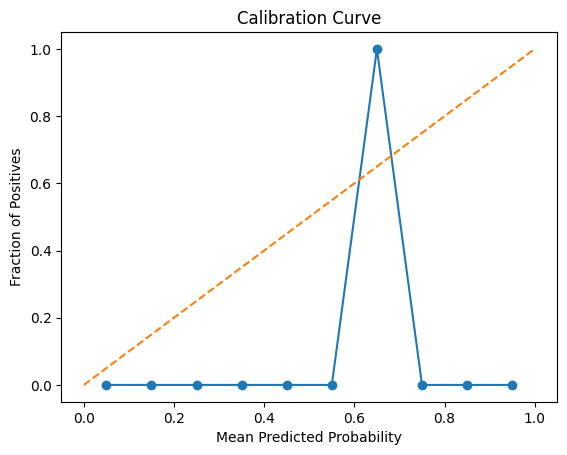

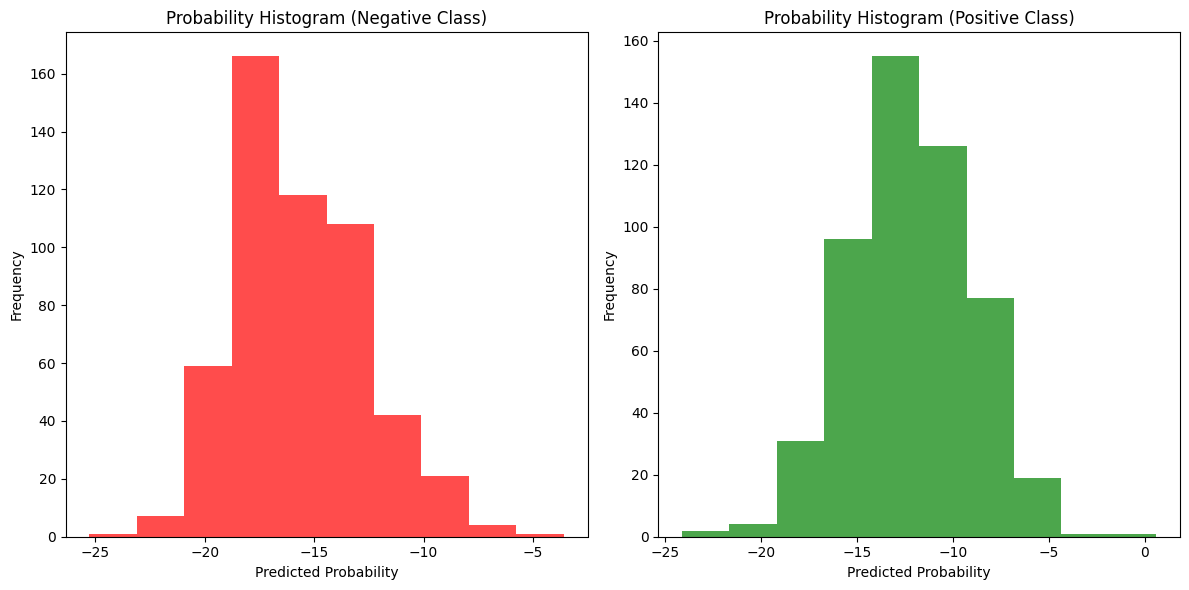

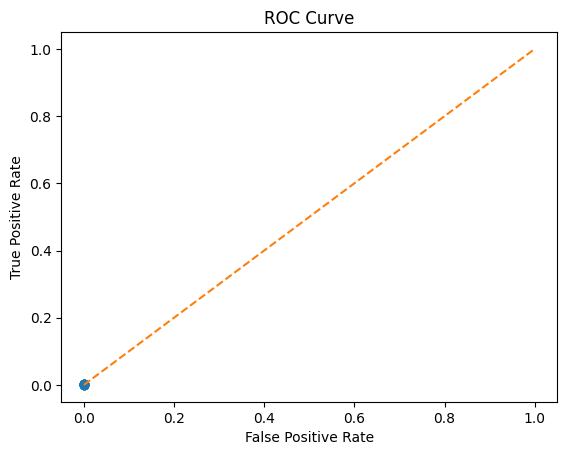

{'Confusion Matrix': [527, 0, 511, 1],
 'Accuracy': 0.5081809432146295,
 'Precision': 1.0,
 'Recall': 0.001953125,
 'Specificity': 1.0,
 'F1 Score': 0.003898635477582846}

In [44]:
y_test_prob_lasso = lasso_model.predict(X_test)
classification_report(y_test, y_test_prob_lasso, 1)

## 2.2: Ridge

The optimum value of C based on accuracy is: 1e-08


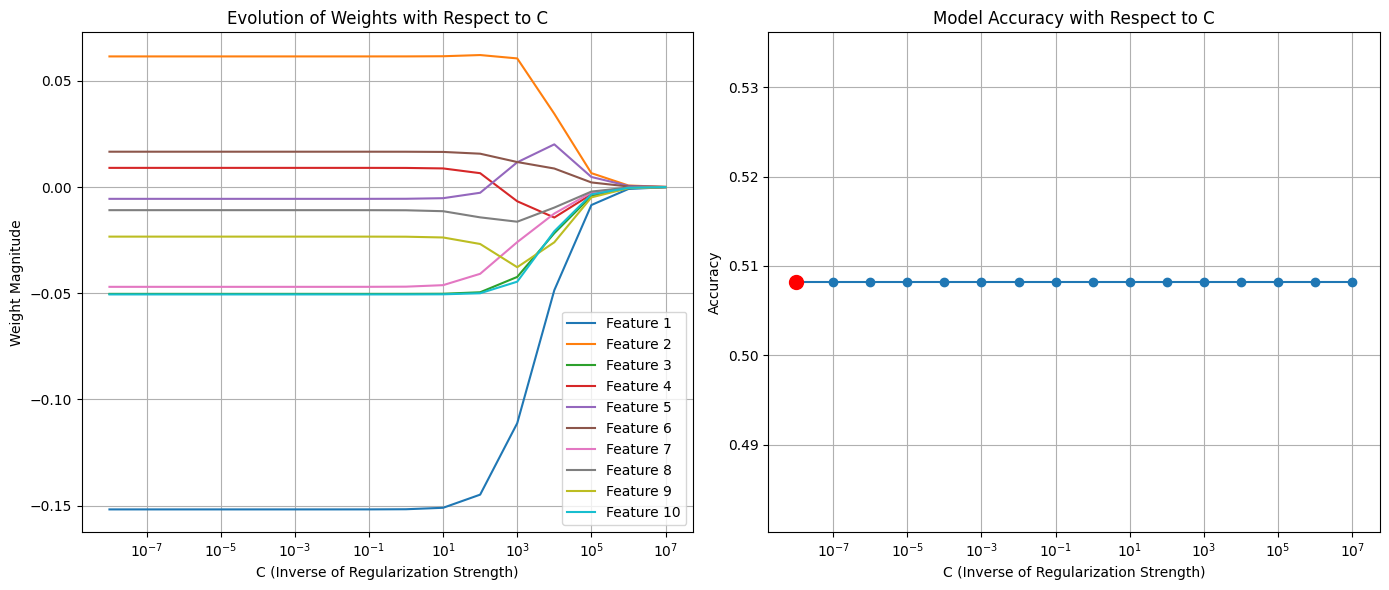

In [12]:
ridge_model = Ridge(alpha=0.01)  # Puedes ajustar el valor de alpha según sea necesario
ridge_model.fit(X_train, y_train)
# predictions = ridge_model.predict(X_test)

pow_min = -8
pow_max = 7

C_values = [10**i for i in range(pow_min, pow_max+1)]  # Vector of \lambda (regularization parameters)
weights_evolution = []  # To store the final weights for each C
accuracies = []

for C in C_values:
    model = Ridge(alpha=C)  # Create a new Lasso model with the current C value
    model.fit(X_train, y_train)
    weights_evolution.append(model.coef_)
    
    # Predict and calculate accuracy
    y_pred = logreg_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)

# Plotting the evolution of weights
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
for feature_index in range(len(weights_evolution[0])):
    weight_trajectory = [weights[feature_index] for weights in weights_evolution]
    plt.plot(C_values, weight_trajectory, label=f'Feature {feature_index + 1}')
plt.xscale('log')
plt.xlabel('C (Inverse of Regularization Strength)')
plt.ylabel('Weight Magnitude')
plt.title('Evolution of Weights with Respect to C')
plt.legend(loc='best')
plt.grid(True)

max_accuracy = max(accuracies)
idx = accuracies.index(max_accuracy)
optimum_C = C_values[idx]

print(f"The optimum value of C based on accuracy is: {optimum_C}")

# Plotting accuracy as a function of C
plt.subplot(1, 2, 2)
plt.plot(C_values, accuracies, marker='o', linestyle='-')
plt.plot(optimum_C, max_accuracy, 'ro', markersize=10, label='Optimum C')
plt.xscale('log')
plt.xlabel('C (Inverse of Regularization Strength)')
plt.ylabel('Accuracy')
plt.title('Model Accuracy with Respect to C')
plt.grid(True)

plt.tight_layout()
plt.show()



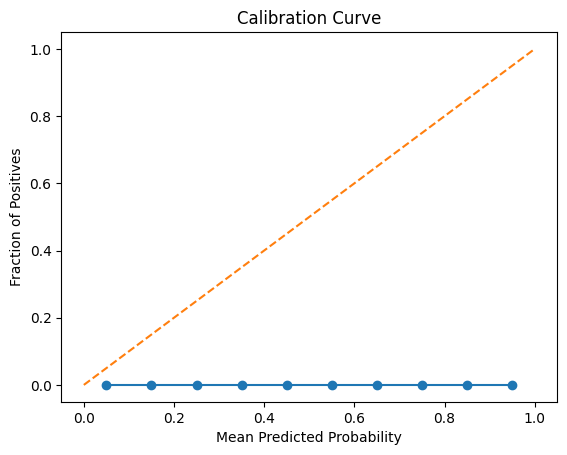

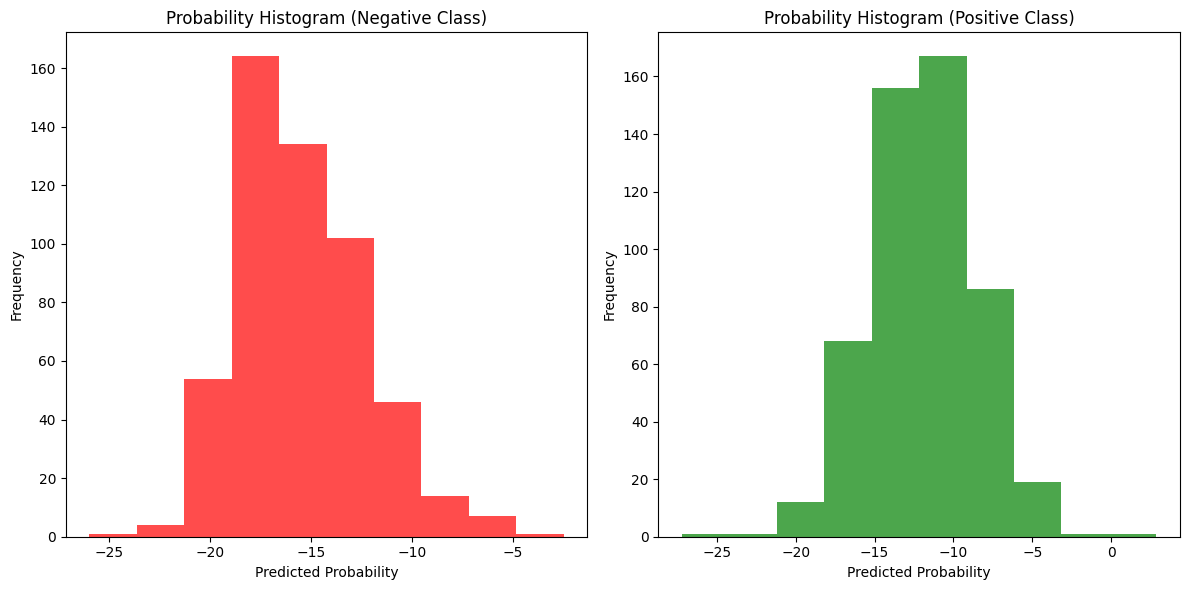

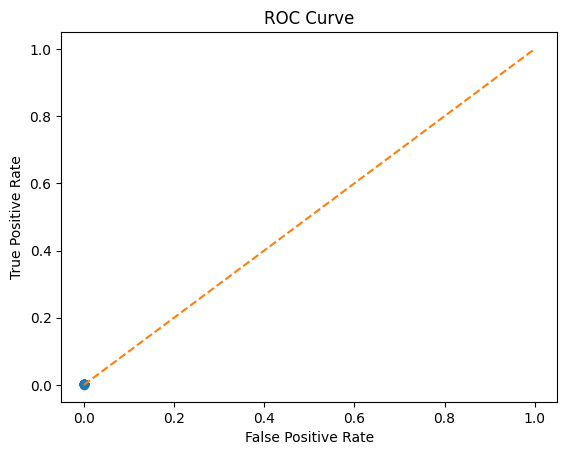

{'Confusion Matrix': [527, 0, 511, 1],
 'Accuracy': 0.5081809432146295,
 'Precision': 1.0,
 'Recall': 0.001953125,
 'Specificity': 1.0,
 'F1 Score': 0.003898635477582846}

In [13]:
y_test_prob_ridge = ridge_model.predict(X_test)
classification_report(y_test, y_test_prob_ridge, 1)

## 2.3: Elastic Net

The optimum value of C based on accuracy is: 1e-08


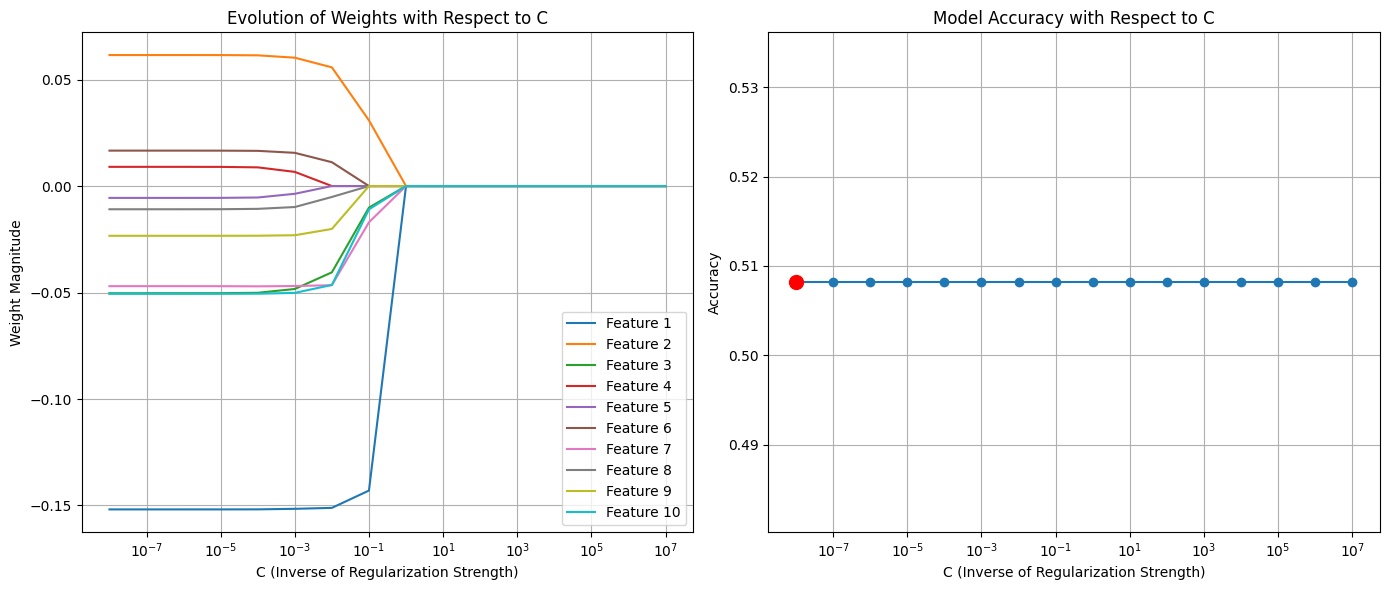

In [14]:
elasticnet_model = ElasticNet(alpha=1.0, l1_ratio=0.5)  # Puedes ajustar el valor de alpha y l1_ratio según sea necesario
elasticnet_model.fit(X_train, y_train)

pow_min = -8
pow_max = 7

C_values = [10**i for i in range(pow_min, pow_max+1)]  # Vector of \lambda (regularization parameters)
weights_evolution = []  # To store the final weights for each C
accuracies = []

for C in C_values:
    model = ElasticNet(alpha=C)  # Create a new Lasso model with the current C value
    model.fit(X_train, y_train)
    weights_evolution.append(model.coef_)
    
    # Predict and calculate accuracy
    y_pred = logreg_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)

# Plotting the evolution of weights
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
for feature_index in range(len(weights_evolution[0])):
    weight_trajectory = [weights[feature_index] for weights in weights_evolution]
    plt.plot(C_values, weight_trajectory, label=f'Feature {feature_index + 1}')
plt.xscale('log')
plt.xlabel('C (Inverse of Regularization Strength)')
plt.ylabel('Weight Magnitude')
plt.title('Evolution of Weights with Respect to C')
plt.legend(loc='best')
plt.grid(True)

max_accuracy = max(accuracies)
idx = accuracies.index(max_accuracy)
optimum_C = C_values[idx]

print(f"The optimum value of C based on accuracy is: {optimum_C}")

# Plotting accuracy as a function of C
plt.subplot(1, 2, 2)
plt.plot(C_values, accuracies, marker='o', linestyle='-')
plt.plot(optimum_C, max_accuracy, 'ro', markersize=10, label='Optimum C')
plt.xscale('log')
plt.xlabel('C (Inverse of Regularization Strength)')
plt.ylabel('Accuracy')
plt.title('Model Accuracy with Respect to C')
plt.grid(True)

plt.tight_layout()
plt.show()



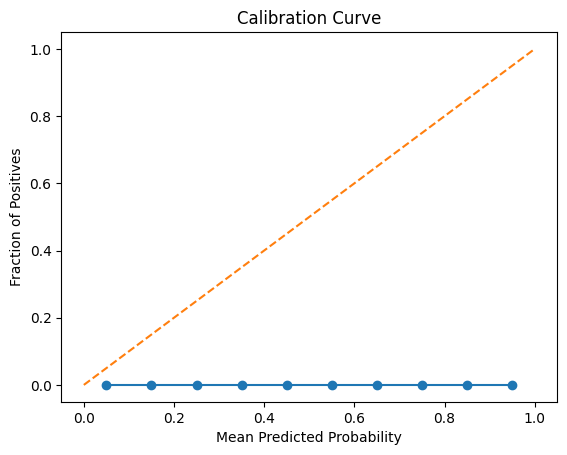

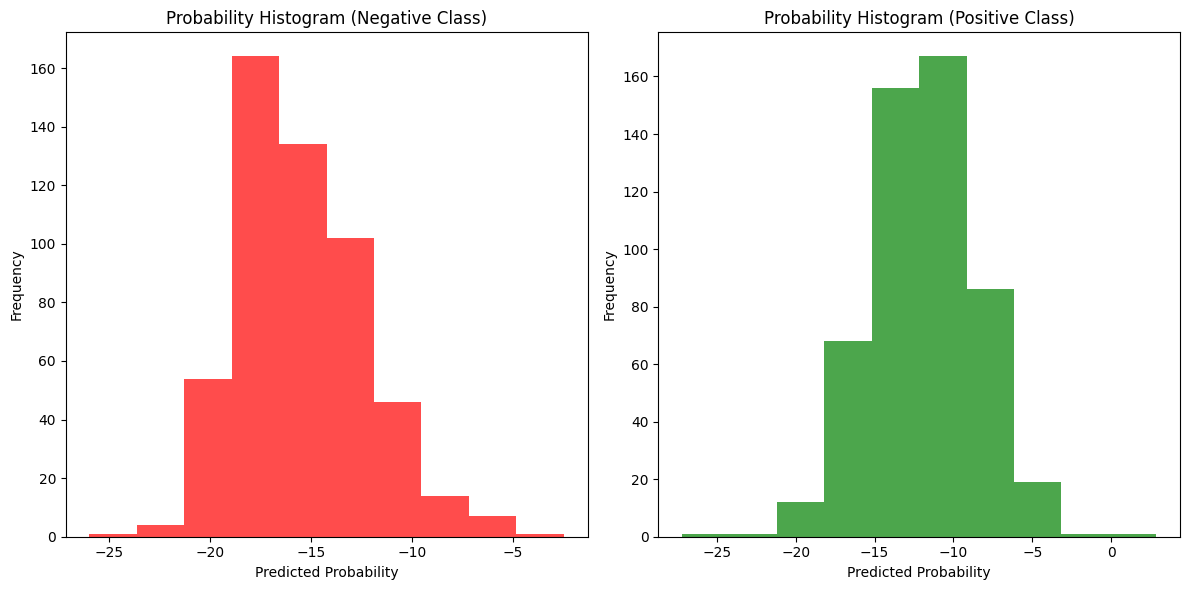

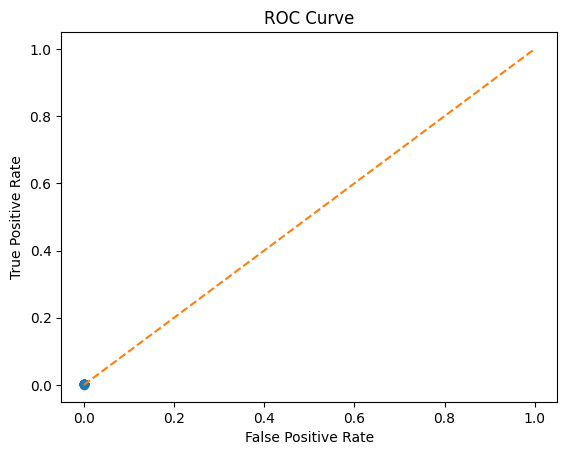

{'Confusion Matrix': [527, 0, 511, 1],
 'Accuracy': 0.5081809432146295,
 'Precision': 1.0,
 'Recall': 0.001953125,
 'Specificity': 1.0,
 'F1 Score': 0.003898635477582846}

In [15]:
elasticnet_model = ElasticNet(alpha=1e-08, l1_ratio=0.5)  # Puedes ajustar el valor de alpha y l1_ratio según sea necesario
elasticnet_model.fit(X_train, y_train)
y_test_prob_elasticnet = elasticnet_model.predict(X_test)
classification_report(y_test, y_test_prob_elasticnet, 1)

## 3: Random Forest

In [16]:
randomforest_model = RandomForestClassifier()
randomforest_model.fit(X_train, y_train)

RandomForestClassifier()

Optimal n estimators: 95 with a score of 0.7273807044339535


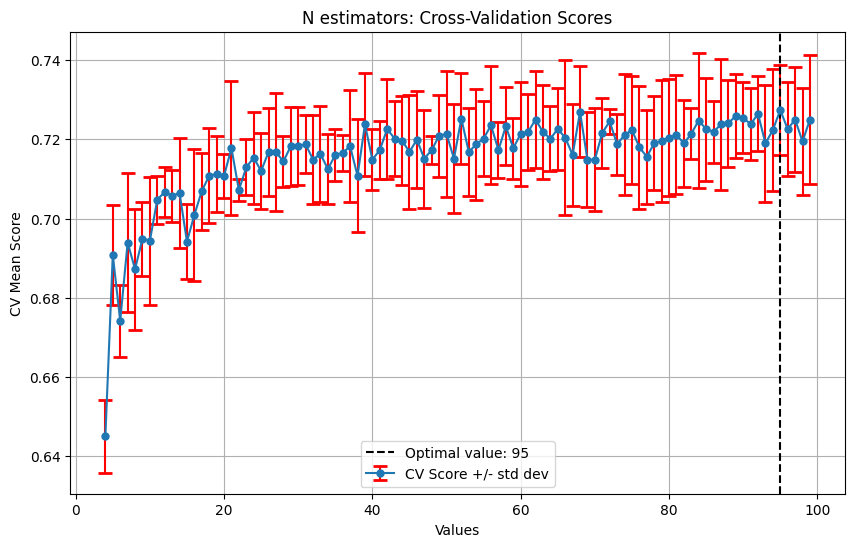

In [17]:
values = range(4,100)
mean_scores, std_scores, optimal_n_estimators_rf, highest_score = cv_model(randomforest_model, X_train, y_train, values, "n_estimators")

print(f"Optimal n estimators: {optimal_n_estimators_rf} with a score of {highest_score}")

# Plotting
plt.figure(figsize=(10, 6))
plt.errorbar(values, mean_scores, yerr=std_scores, fmt='-o', ecolor='r', capsize=5, capthick=2, markersize=5, label='CV Score +/- std dev')
plt.axvline(x=optimal_n_estimators_rf, linestyle='--', color='k', label=f'Optimal value: {optimal_n_estimators_rf}')

plt.title('N estimators: Cross-Validation Scores')
plt.xlabel('Values')
plt.ylabel('CV Mean Score')
plt.legend()
plt.grid(True)
plt.show()


Optimal depth: 6 with a score of 0.7302693696195501


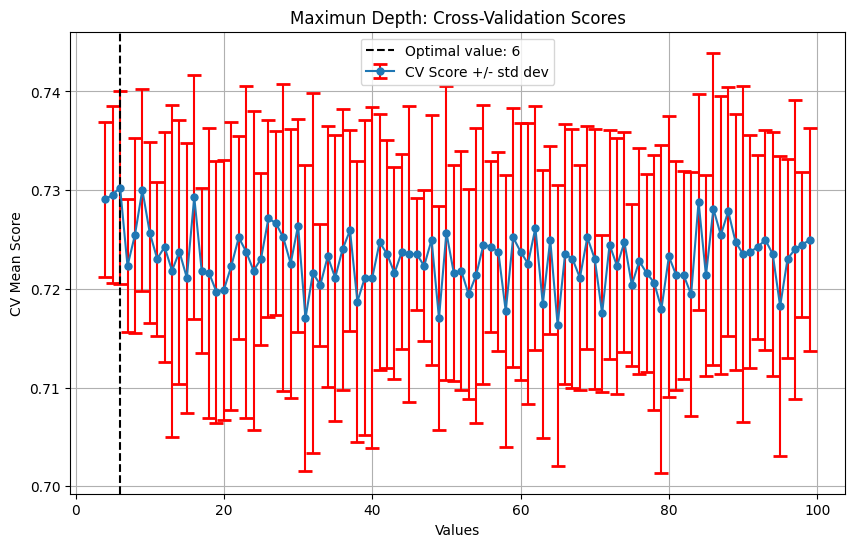

In [18]:
values = range(4,100)
mean_scores, std_scores, optimal_max_depth_rf, highest_score = cv_model(randomforest_model, X_train, y_train, values, "max_depth")

print(f"Optimal depth: {optimal_max_depth_rf} with a score of {highest_score}")

# Plotting
plt.figure(figsize=(10, 6))
plt.errorbar(values, mean_scores, yerr=std_scores, fmt='-o', ecolor='r', capsize=5, capthick=2, markersize=5, label='CV Score +/- std dev')
plt.axvline(x=optimal_max_depth_rf, linestyle='--', color='k', label=f'Optimal value: {optimal_max_depth_rf}')

plt.title('Maximun Depth: Cross-Validation Scores')
plt.xlabel('Values')
plt.ylabel('CV Mean Score')
plt.legend()
plt.grid(True)
plt.show()


Optimal min samples split: 60 with a score of 0.7331574562621493


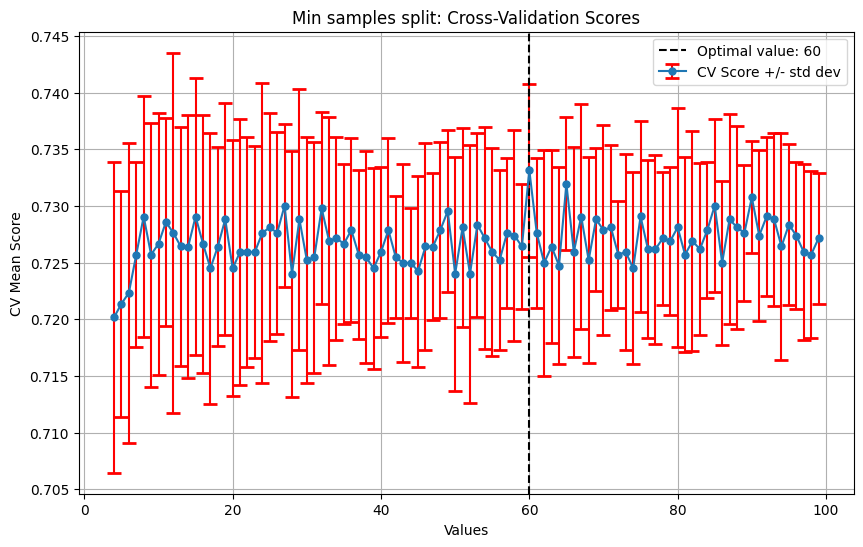

In [19]:
values = range(4,100)
mean_scores, std_scores, optimal_mss_rf, highest_score = cv_model(randomforest_model, X_train, y_train, values, "min_samples_split")

print(f"Optimal min samples split: {optimal_mss_rf} with a score of {highest_score}")

# Plotting
plt.figure(figsize=(10, 6))
plt.errorbar(values, mean_scores, yerr=std_scores, fmt='-o', ecolor='r', capsize=5, capthick=2, markersize=5, label='CV Score +/- std dev')
plt.axvline(x=optimal_mss_rf, linestyle='--', color='k', label=f'Optimal value: {optimal_mss_rf}')

plt.title('Min samples split: Cross-Validation Scores')
plt.xlabel('Values')
plt.ylabel('CV Mean Score')
plt.legend()
plt.grid(True)
plt.show()


Optimal min samples leaf: 43 with a score of 0.7309925483661945


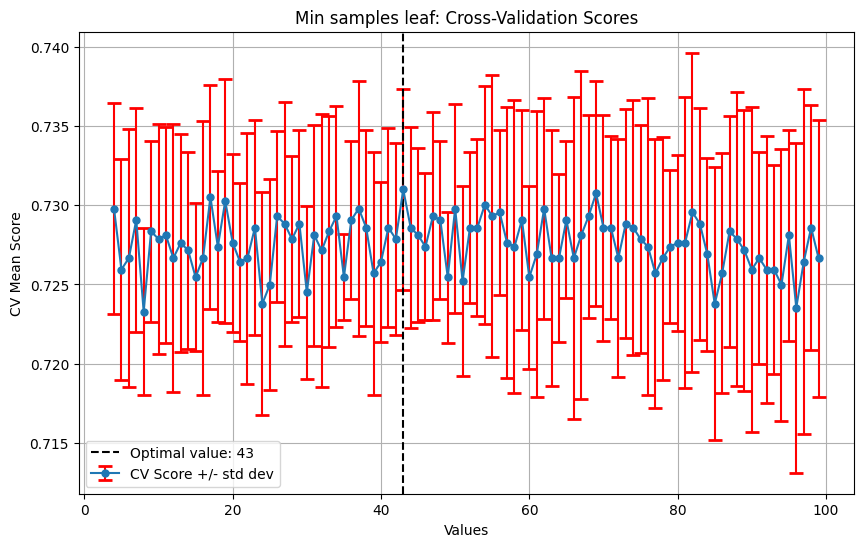

In [20]:
values = range(4,100)
mean_scores, std_scores, optimal_msl_rf, highest_score = cv_model(randomforest_model, X_train, y_train, values, "min_samples_leaf")

print(f"Optimal min samples leaf: {optimal_msl_rf} with a score of {highest_score}")

# Plotting
plt.figure(figsize=(10, 6))
plt.errorbar(values, mean_scores, yerr=std_scores, fmt='-o', ecolor='r', capsize=5, capthick=2, markersize=5, label='CV Score +/- std dev')
plt.axvline(x=optimal_msl_rf, linestyle='--', color='k', label=f'Optimal value: {optimal_msl_rf}')

plt.title('Min samples leaf: Cross-Validation Scores')
plt.xlabel('Values')
plt.ylabel('CV Mean Score')
plt.legend()
plt.grid(True)
plt.show()


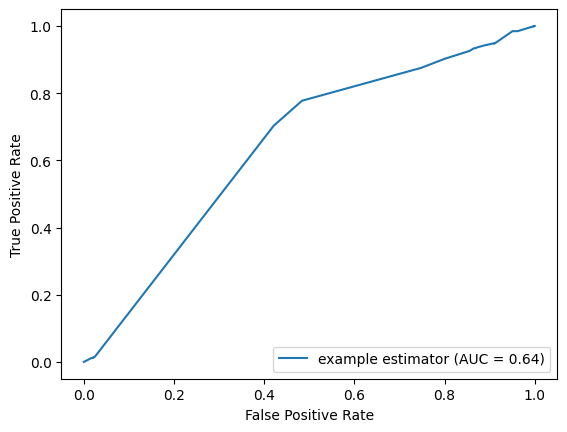

In [21]:
randomforest_model = RandomForestClassifier(n_estimators=optimal_n_estimators_rf,max_depth=optimal_max_depth_rf,min_samples_split=optimal_mss_rf,min_samples_leaf=optimal_msl_rf)
randomforest_model.fit(X_train, y_train)
y_test_prob_rfc = randomforest_model.predict_log_proba(X_test)

from sklearn import metrics

y = np.array(y_test.astype("int"))
pred = y_test_prob_rfc[:,1] 
fpr, tpr, thresholds = metrics.roc_curve(y, pred)
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                  estimator_name='example estimator')
display.plot()
plt.show()

## 4: Bootstrap Aggregatin

In [22]:
bootstrap = BaggingClassifier()
bootstrap.fit(X_train, y_train)

BaggingClassifier()

Optimal n estimators: 85 with a score of 0.7208825094881051


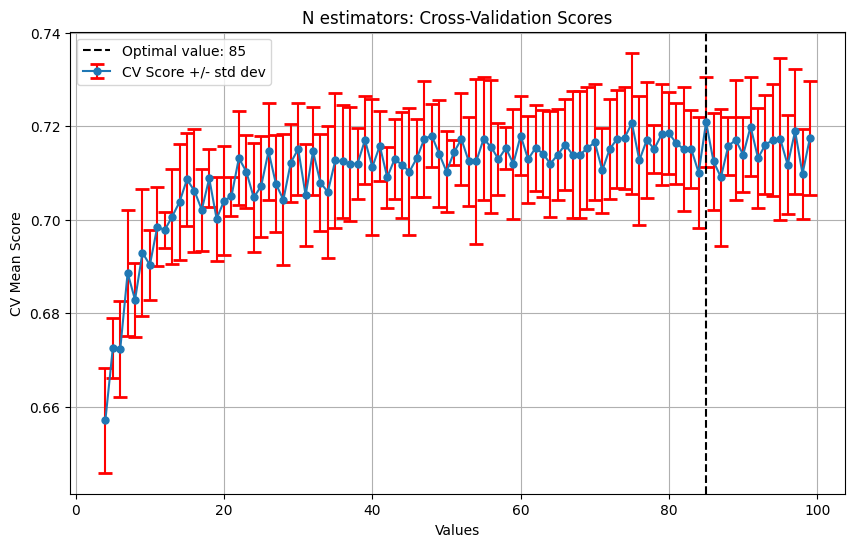

In [23]:
values = range(4,100)
mean_scores, std_scores, optimal_n_estimators_BA, highest_score = cv_model(bootstrap, X_train, y_train, values, "n_estimators")

print(f"Optimal n estimators: {optimal_n_estimators_BA} with a score of {highest_score}")

# Plotting
plt.figure(figsize=(10, 6))
plt.errorbar(values, mean_scores, yerr=std_scores, fmt='-o', ecolor='r', capsize=5, capthick=2, markersize=5, label='CV Score +/- std dev')
plt.axvline(x=optimal_n_estimators_BA, linestyle='--', color='k', label=f'Optimal value: {optimal_n_estimators_BA}')

plt.title('N estimators: Cross-Validation Scores')
plt.xlabel('Values')
plt.ylabel('CV Mean Score')
plt.legend()
plt.grid(True)
plt.show()


Optimal n estimators: 72 with a score of 0.7338771637508099


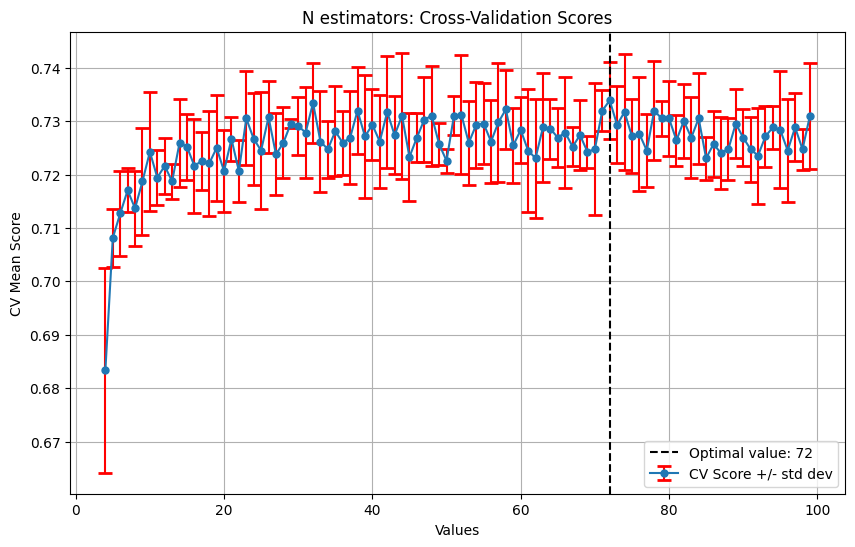

In [24]:
values = range(4,100)
mean_scores, std_scores, optimal_max_samples_BA, highest_score = cv_model(bootstrap, X_train, y_train, values, "max_samples")

print(f"Optimal n estimators: {optimal_max_samples_BA} with a score of {highest_score}")

# Plotting
plt.figure(figsize=(10, 6))
plt.errorbar(values, mean_scores, yerr=std_scores, fmt='-o', ecolor='r', capsize=5, capthick=2, markersize=5, label='CV Score +/- std dev')
plt.axvline(x=optimal_max_samples_BA, linestyle='--', color='k', label=f'Optimal value: {optimal_max_samples_BA}')

plt.title('N estimators: Cross-Validation Scores')
plt.xlabel('Values')
plt.ylabel('CV Mean Score')
plt.legend()
plt.grid(True)
plt.show()


C:\Users\meryg\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\tree\_classes.py:1035: RuntimeWarning: divide by zero encountered in log
  return np.log(proba)
C:\Users\meryg\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\tree\_classes.py:1035: RuntimeWarning: divide by zero encountered in log
  return np.log(proba)
C:\Users\meryg\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\tree\_classes.py:1035: RuntimeWarning: divide by zero encountered in log
  return np.log(proba)
C:\Users\meryg\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\tree\_classes.py:1035: RuntimeWarning: divide by zero encountered in log
  return np.log(proba)
C:\Users\meryg\AppData\Local

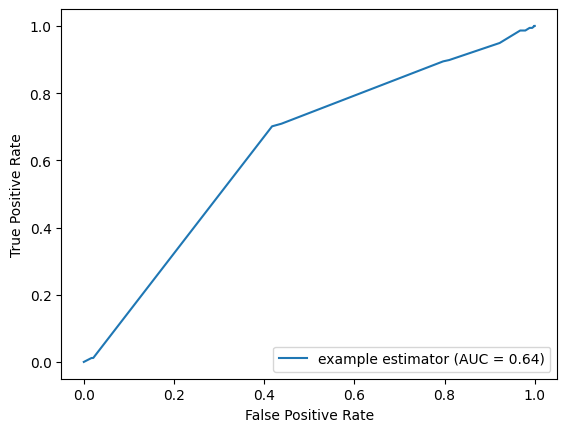

In [25]:
bootstrap = BaggingClassifier(n_estimators=optimal_n_estimators_BA, max_samples=optimal_max_samples_BA)
bootstrap.fit(X_train, y_train)
y_test_prob_bootstrap = bootstrap.predict_log_proba(X_test)

y = np.array(y_test.astype("int"))
pred = y_test_prob_bootstrap[:,1] 
fpr, tpr, thresholds = metrics.roc_curve(y, pred)
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                  estimator_name='example estimator')
display.plot()
plt.show()

## 5: Árboles de Clasificación

In [26]:
arbol_clasificador = DecisionTreeClassifier()
arbol_clasificador.fit(X_train, y_train)

DecisionTreeClassifier()

Optimal depth: 5 with a score of 0.7037984240488753


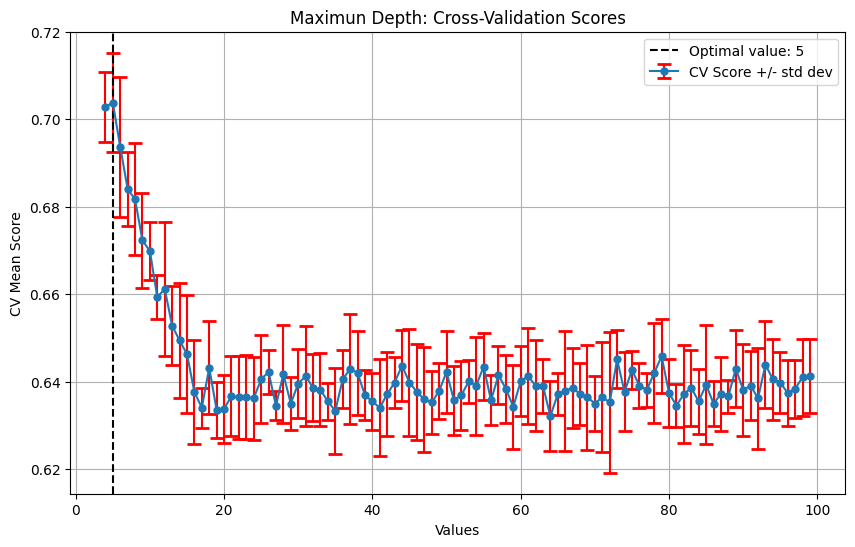

In [27]:
values = range(4,100)
mean_scores, std_scores, optimal_max_depth_TC, highest_score = cv_model(arbol_clasificador, X_train, y_train, values, "max_depth")

print(f"Optimal depth: {optimal_max_depth_TC} with a score of {highest_score}")

# Plotting
plt.figure(figsize=(10, 6))
plt.errorbar(values, mean_scores, yerr=std_scores, fmt='-o', ecolor='r', capsize=5, capthick=2, markersize=5, label='CV Score +/- std dev')
plt.axvline(x=optimal_max_depth_TC, linestyle='--', color='k', label=f'Optimal value: {optimal_max_depth_TC}')

plt.title('Maximun Depth: Cross-Validation Scores')
plt.xlabel('Values')
plt.ylabel('CV Mean Score')
plt.legend()
plt.grid(True)
plt.show()


Optimal min samples split: 95 with a score of 0.6905630958992872


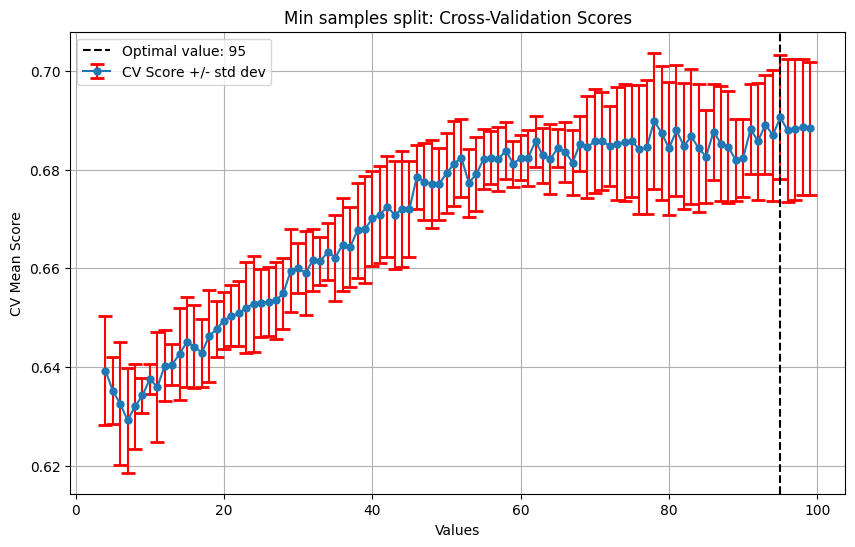

In [28]:
values = range(4,100)
mean_scores, std_scores, optimal_mss_TC, highest_score = cv_model(arbol_clasificador, X_train, y_train, values, "min_samples_split")

print(f"Optimal min samples split: {optimal_mss_TC} with a score of {highest_score}")

# Plotting
plt.figure(figsize=(10, 6))
plt.errorbar(values, mean_scores, yerr=std_scores, fmt='-o', ecolor='r', capsize=5, capthick=2, markersize=5, label='CV Score +/- std dev')
plt.axvline(x=optimal_mss_TC, linestyle='--', color='k', label=f'Optimal value: {optimal_mss_TC}')

plt.title('Min samples split: Cross-Validation Scores')
plt.xlabel('Values')
plt.ylabel('CV Mean Score')
plt.legend()
plt.grid(True)
plt.show()


Optimal min samples leaf: 89 with a score of 0.7119819147459039


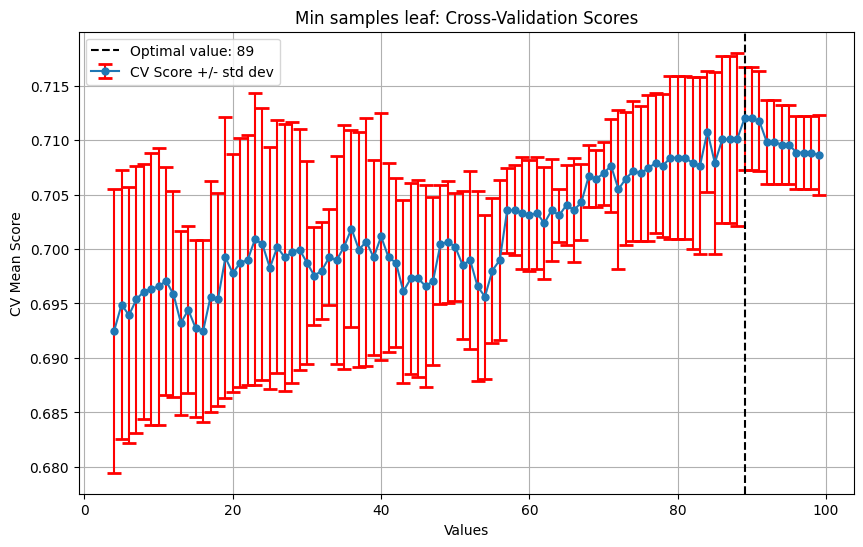

In [29]:
values = range(4,100)
mean_scores, std_scores, optimal_msl_TC, highest_score = cv_model(arbol_clasificador, X_train, y_train, values, "min_samples_leaf")

print(f"Optimal min samples leaf: {optimal_msl_TC} with a score of {highest_score}")

# Plotting
plt.figure(figsize=(10, 6))
plt.errorbar(values, mean_scores, yerr=std_scores, fmt='-o', ecolor='r', capsize=5, capthick=2, markersize=5, label='CV Score +/- std dev')
plt.axvline(x=optimal_msl_TC, linestyle='--', color='k', label=f'Optimal value: {optimal_msl_TC}')

plt.title('Min samples leaf: Cross-Validation Scores')
plt.xlabel('Values')
plt.ylabel('CV Mean Score')
plt.legend()
plt.grid(True)
plt.show()


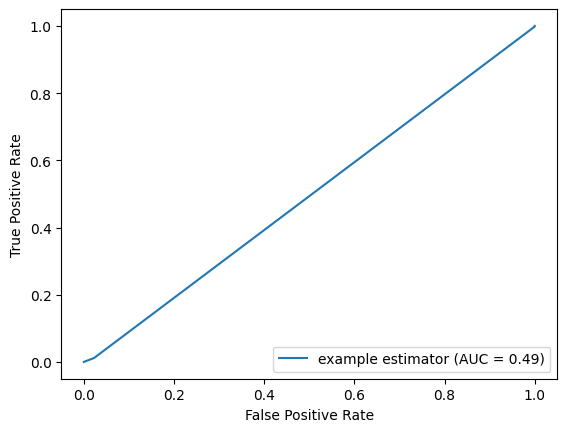

In [30]:
arbol_clasificador = DecisionTreeClassifier(max_depth=optimal_max_depth_TC, min_samples_split=optimal_mss_TC, min_samples_leaf=optimal_msl_TC)
arbol_clasificador.fit(X_train, y_train)
y_test_prob_arbol_clasificador = arbol_clasificador.predict_log_proba(X_test)

y = np.array(y_test.astype("int"))
pred = y_test_prob_arbol_clasificador[:,1] 
fpr, tpr, thresholds = metrics.roc_curve(y, pred)
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                  estimator_name='example estimator')
display.plot()
plt.show()

## 6: Boosting

In [31]:
boosting = GradientBoostingClassifier()
boosting.fit(X_train, y_train)

GradientBoostingClassifier()

Optimal n estimators: 70 with a score of 0.7281015690086087


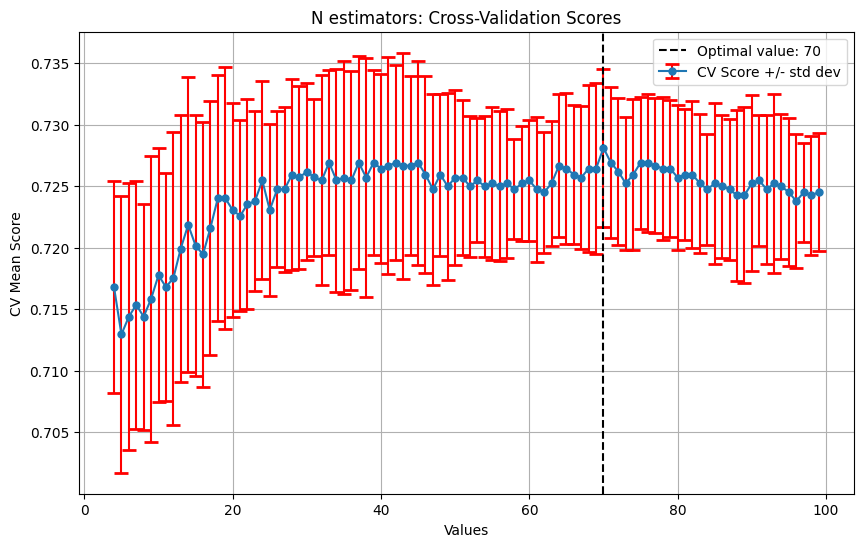

In [32]:
values = range(4,100)
mean_scores, std_scores, optimal_n_estimartors_BST, highest_score = cv_model(boosting, X_train, y_train, values, "n_estimators")

print(f"Optimal n estimators: {optimal_n_estimartors_BST} with a score of {highest_score}")

# Plotting
plt.figure(figsize=(10, 6))
plt.errorbar(values, mean_scores, yerr=std_scores, fmt='-o', ecolor='r', capsize=5, capthick=2, markersize=5, label='CV Score +/- std dev')
plt.axvline(x=optimal_n_estimartors_BST, linestyle='--', color='k', label=f'Optimal value: {optimal_n_estimartors_BST}')

plt.title('N estimators: Cross-Validation Scores')
plt.xlabel('Values')
plt.ylabel('CV Mean Score')
plt.legend()
plt.grid(True)
plt.show()


Optimal n estimators: 4 with a score of 0.5841887091548644


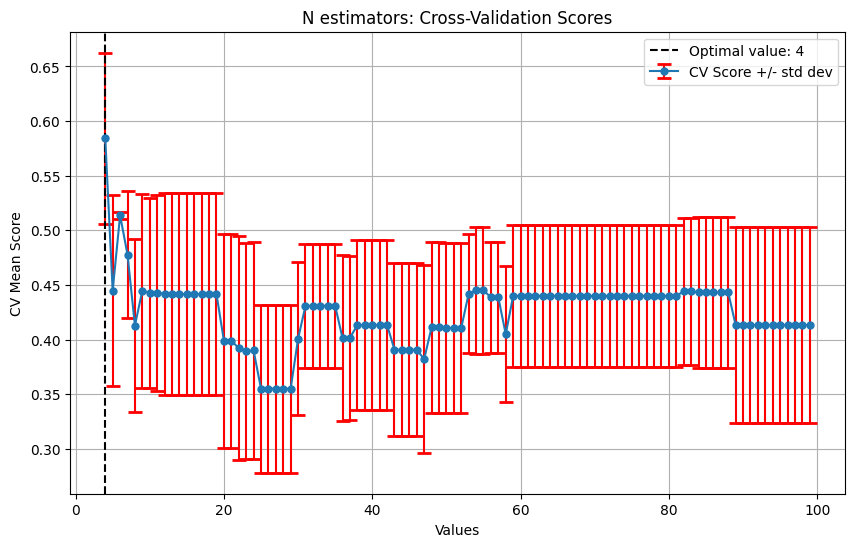

In [33]:
values = range(4,100)
mean_scores, std_scores, optimal_lr_BST, highest_score = cv_model(boosting, X_train, y_train, values, "learning_rate")

print(f"Optimal n estimators: {optimal_lr_BST} with a score of {highest_score}")

# Plotting
plt.figure(figsize=(10, 6))
plt.errorbar(values, mean_scores, yerr=std_scores, fmt='-o', ecolor='r', capsize=5, capthick=2, markersize=5, label='CV Score +/- std dev')
plt.axvline(x=optimal_lr_BST, linestyle='--', color='k', label=f'Optimal value: {optimal_lr_BST}')

plt.title('N estimators: Cross-Validation Scores')
plt.xlabel('Values')
plt.ylabel('CV Mean Score')
plt.legend()
plt.grid(True)
plt.show()


## 7: SVM

In [35]:
svm_model = SVC(cache_size=7000)
svm_model.fit(X_train, y_train)

SVC(cache_size=7000)

In [48]:
from sklearn.model_selection import GridSearchCV
param_grid = {'C': [0.1,1,10], 'gamma': [0.1,1,10], 'kernel': ['rbf']}

# Realizar la búsqueda de hiperparámetros con validación cruzada
grid_search = GridSearchCV(svm_model, param_grid, cv=5)
grid_search.fit(X_train, y_train)
print("Model fit.")

# Obtener los mejores parámetros y el mejor kernel encontrados
best_params = grid_search.best_params_
print(best_params)
best_kernel = best_params['kernel']
print("El mejor kernel encontrado es:", best_kernel)

Model fit.
{'C': 0.1, 'gamma': 0.1, 'kernel': 'rbf'}
El mejor kernel encontrado es: rbf


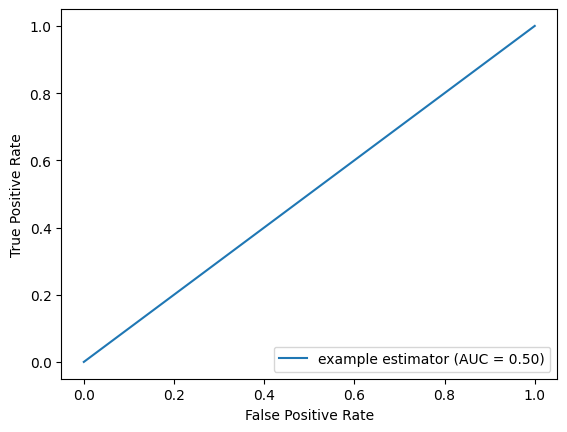

In [49]:
svm_model_rbf = SVC(C=1,gamma=0.1,kernel="rbf",cache_size=7000, probability=True)
svm_model_rbf.fit(X_train, y_train)
y_test_prob_svm_rbf = svm_model_rbf.predict_log_proba(X_test)
y = np.array(y_test.astype("int"))
pred = y_test_prob_svm_rbf[:,1]
fpr, tpr, thresholds = metrics.roc_curve(y, pred)
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                  estimator_name='example estimator')
display.plot()
plt.show()

In [50]:
from sklearn.model_selection import GridSearchCV
param_grid = {'C': [0.1,1,10], 'gamma': [0.1,1,10], 'kernel': ['linear']}

# Realizar la búsqueda de hiperparámetros con validación cruzada
grid_search = GridSearchCV(svm_model, param_grid, cv=5)
grid_search.fit(X_train, y_train)
print("Model fit.")

# Obtener los mejores parámetros y el mejor kernel encontrados
best_params = grid_search.best_params_
print(best_params)
best_kernel = best_params['kernel']
print("El mejor kernel encontrado es:", best_kernel)

Model fit.
{'C': 10, 'gamma': 0.1, 'kernel': 'linear'}
El mejor kernel encontrado es: linear


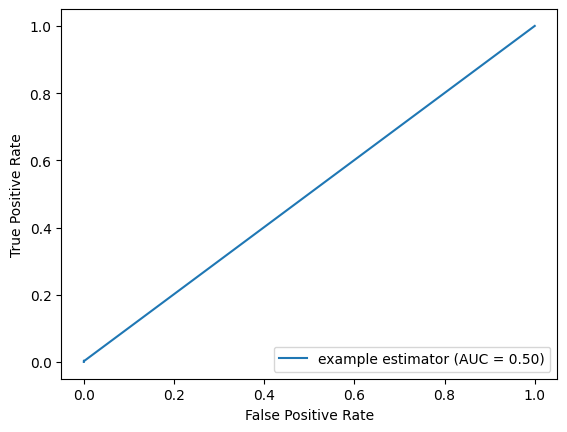

In [51]:
svm_model_linear = SVC(C=1,gamma=0.1,kernel="linear",cache_size=7000, probability=True)
svm_model_linear.fit(X_train, y_train)
y_test_prob_svm_linear = svm_model_linear.predict_log_proba(X_test)
y = np.array(y_test.astype("int"))
pred = y_test_prob_svm_linear[:,1]
fpr, tpr, thresholds = metrics.roc_curve(y, pred)
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                  estimator_name='example estimator')
display.plot()
plt.show()

In [52]:
from utils import evaluate_classification_metrics

In [55]:
modelos = [knn_model,logreg_model,lasso_model,ridge_model,elasticnet_model,randomforest_model,boosting,arbol_clasificador,bootstrap,svm_model_linear,svm_model_rbf]
metricas_modelos = {}
for model in modelos:
    metricas_model = evaluate_classification_metrics(y_test, model.predict(X_test), 1)
    metricas_model = {metrica: round(float(valor), 3) if isinstance(valor, (int, float)) else valor for metrica,valor in metricas_model.items()}
    metricas_modelos[type(model).__name__] = metricas_model
    
# Crear un DataFrame a partir de los diccionarios de métricas
df_metricas = pd.DataFrame(metricas_modelos).T

# Mostrar el DataFrame
print(df_metricas)


                               Confusion Matrix Accuracy Precision Recall  \
KNeighborsClassifier          [525, 2, 490, 22]    0.526     0.917  0.043   
LogisticRegression             [527, 0, 511, 1]    0.508       1.0  0.002   
Lasso                          [527, 0, 512, 0]    0.507       0.0    0.0   
Ridge                          [527, 0, 512, 0]    0.507       0.0    0.0   
ElasticNet                     [527, 0, 512, 0]    0.507       0.0    0.0   
RandomForestClassifier         [518, 9, 506, 6]    0.504       0.4  0.012   
GradientBoostingClassifier   [47, 480, 26, 486]    0.513     0.503  0.949   
DecisionTreeClassifier         [527, 0, 512, 0]    0.507       0.0    0.0   
BaggingClassifier           [100, 427, 52, 460]    0.539     0.519  0.898   
SVC                            [0, 527, 0, 512]    0.493     0.493    1.0   

                           Specificity F1 Score  
KNeighborsClassifier             0.996    0.082  
LogisticRegression                 1.0    0.004  
La